# Objective function approximation

## Packages 

In [1]:
import numpy as np
from simulations import simulations 
from scipy.special import factorial
import pandas as pd
import stoch_int 
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
from scipy.stats import dirichlet
from scipy.special import gammaln
import time
import methods as mh

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Objective functions and distributions

In [2]:
# setting the functions and distributions
def objective_function(x: np.array, alpha: np.array, sigma = None, n = None, eta = None):
    # checking if x is non-empty
    if x.size == 0:
        raise ValueError('Error: input array x is empty')
    
    # Reshape x if it's 1D to ensure it has the right shape
    if x.ndim == 1:
        x = x.reshape(1, -1)
    
    # setting default values for n and eta if not provided
    if n is None:
        n = np.zeros(len(alpha))
        
    if eta is None:
        eta = np.ones(len(alpha))

    return np.prod(np.power(x, (alpha + n * eta)), axis=1) * np.exp(-sigma * (np.sum(x ** 2, axis=1)))

def wrapped_objective_function(x:np.array, eta):
    global sigma, alpha, n
    return objective_function(x,alpha, sigma, n, eta)

def target_distribution(x, eta=None):
    return wrapped_objective_function(x, eta)

def proposal_distribution(num_samples, alpha_proposal):
    # Sampling from the Dirichlet proposal distribution
    return dirichlet.rvs(alpha_proposal, size=num_samples)

def log_objective_function(x: np.array, alpha: np.array, sigma=None, n=None, eta=None, epsilon=1e-10):
    # checking if x is non-empty
    if x.size == 0:
        raise ValueError('Error: input array x is empty')
    
    # setting default values for n and eta if not provided
    if n is None:
        n = np.zeros(len(alpha))
        
    if eta is None:
        eta = np.ones(len(alpha))

    # computing the scaled alpha
    alpha_scaled = alpha + (n * eta)
    
    # adding a small value to x to avoid log(0)
    x = np.clip(x, epsilon, None)  # Ensure x values are within [epsilon, inf]

    # Reshape x if it's 1D to ensure it has the right shape
    if x.ndim == 1:
        x = x.reshape(1, -1)
    
    # computing log of the product term
    log_prod = np.sum(alpha_scaled * np.log(x), axis=1)
    
    # computing log of the exponential term
    log_exp = -sigma * np.sum(x ** 2, axis=1)

    # combining both parts
    return log_prod + log_exp

# Define the wrapped function
def wrapped_log_objective_function(p, eta):
    global n, alpha, sigma
    return log_objective_function(p, alpha=alpha, sigma=sigma, n=n, eta=eta)


# Dirichlet density function
def dirichlet_density(x, alpha, epsilon=1e-10):
    # Clip x to avoid taking the log of zero
    x = np.clip(x, epsilon, 1 - epsilon)
    B = np.sum(gammaln(alpha)) - gammaln(np.sum(alpha))
    return np.exp(np.sum((alpha - 1) * np.log(x), axis=1) - B)

# Handle non-finite values
def handle_non_finite(values, epsilon=1e-10):
    if not np.all(np.isfinite(values)):
        print("Non-finite values detected, replacing them.")
        values = np.nan_to_num(values, nan=epsilon, posinf=np.max(values[np.isfinite(values)]), neginf=np.min(values[np.isfinite(values)]))
    return values


# Simplex generation for 3D (2D representation)
def generate_simplex_grid(num_points=100):
    x1 = np.linspace(0, 1, num_points)
    x2 = np.linspace(0, 1, num_points)
    grid = [(x1_i, x2_i) for x1_i in x1 for x2_i in x2 if x1_i + x2_i <= 1.0]
    grid = np.array(grid)
    x3 = 1 - grid[:, 0] - grid[:, 1]
    points = np.column_stack((grid[:, 0], grid[:, 1], x3))
    return points


## Ratio of normalizing constants approximation

### Utility functions

In [3]:
def run_ais_for_alpha_proposals(
    alpha_proposals, 
    proposal_distribution, 
    wrapped_log_objective_function, 
    eta, 
    met_obj, 
    M, 
    interval,
    init,
    burn_in=1, 
    thinning=1
):
    # creating a dictionary to store the results for each alpha proposal
    results_dict_ais_for = {f'alpha_{i+1}': [] for i in range(len(alpha_proposals))}

    # looping over each alpha proposal
    for i, alpha_proposal in enumerate(alpha_proposals):
        print(f'Running AIS with alpha proposal {i+1}: {alpha_proposal}')

        # initializing lists to store results for the current alpha proposal
        results = []
        results_ais_for = []

        # running AIS for the current alpha proposal
        for m in range(M):
            if init:
                # updating initial state using log_importance_sampling
                initial, _ = mh.log_importance_sampling(proposal_distribution, wrapped_log_objective_function, alpha_proposal, eta[0], 1)
                initial = initial.flatten()

                # running AIS with the wrapped log objective function
                result = mh.ais(
                    wrapped_log_objective_function, 
                    alpha_proposal, 
                    eta, 
                    met_obj, 
                    initial=initial, 
                    burn_in=burn_in, 
                    thinning=thinning
                )

                # storing the result for each iteration
                results.append(np.prod(np.exp(result['ratios'])))
                results_ais_for.append(result)
            else:
                # updating final state using log_importance_sampling
                final, _ = mh.log_importance_sampling(proposal_distribution, wrapped_log_objective_function, alpha_proposal, eta[-1], 1)
                final = final.flatten()

                # running AIS with the wrapped log objective function
                result = mh.ais(
                    wrapped_log_objective_function, 
                    alpha_proposal, 
                    eta, 
                    met_obj, 
                    final=final, 
                    burn_in=burn_in, 
                    thinning=thinning
                )

                # storing the result for each iteration
                results.append(np.prod(np.exp(result['ratios'])))
                results_ais_for.append(result)


            # compute and store the mean every 'interval' iterations
            if (m + 1) % interval == 0:
                mean_value = np.mean(results)
                print(f'Mean ratio after {m + 1} iterations for alpha {i+1}: {mean_value}')
                # storing the mean and the current iteration count in the results dictionary
                results_dict_ais_for[f'alpha_{i+1}'].append((m + 1, mean_value))

        # compute the final mean after all iterations for the current alpha proposal
        final_mean = np.mean(results)
        print(f'Final mean ratio for alpha {i+1} after {M} iterations: {final_mean}')

    return results_dict_ais_for

def run_ais_back_experiment(
    eta_ranges, 
    alpha, 
    proposal_distribution, 
    wrapped_log_objective_function, 
    alpha_proposal, 
    M,
    met_obj, 
    bigm_checkpoints, 
    eta_part,
    init,
    burn_in=1, 
    thinning=1
):
    dict = {}

    # iterating over each eta range
    for i, eta_range in enumerate(eta_ranges):
        # creating eta array for the current range
        eta = np.array([np.full(len(alpha), eta_val) for eta_val in eta_range])

        # initializing result and time storage
        results = []
        times = []

        # fixing BigM 
        BigM = M

        # running AIS 
        for m in range(1, BigM + 1):
            # starting the timer
            start_time = time.time()

            if init:
            # updating initial state using log_importance_sampling
                initial, _ = mh.log_importance_sampling(proposal_distribution, wrapped_log_objective_function, alpha_proposal, eta[0], 1)
                initial = initial.flatten()

                # running AIS with the wrapped log objective function
                result = mh.ais(
                    wrapped_log_objective_function, 
                    alpha_proposal, 
                    eta, 
                    met_obj, 
                    initial=initial, 
                    burn_in=burn_in, 
                    thinning=thinning
                )
            else:
                # updating final state using log_importance_sampling
                final, _ = mh.log_importance_sampling(proposal_distribution, wrapped_log_objective_function, alpha_proposal, eta[-1], 1)
                final = final.flatten()

                # running AIS with the wrapped log objective function
                result = mh.ais(
                    wrapped_log_objective_function, 
                    alpha_proposal, 
                    eta, 
                    met_obj, 
                    final=final, 
                    burn_in=burn_in, 
                    thinning=thinning
                )


            # computing and storing the time for this iteration
            elapsed_time = time.time() - start_time
            times.append(elapsed_time)

            # storing the result
            results.append(np.prod(np.exp(result['ratios'])))

            # checking if we've reached a checkpoint
            if m in bigm_checkpoints:
                # computing and store the mean ratio and times for the current checkpoint
                dict[(m, eta_part[i])] = {
                    'mean_ratio': np.mean(results),
                    'times': times[:m]
                }

                # printing output for the current combination of eta and BigM checkpoint
                print(f"Checkpoint reached: eta = {eta_part[i]}, BigM = {m}, mean_ratio = {dict[(m, eta_part[i])]['mean_ratio']}")

    return dict

def run_lis_experiment(
    eta_ranges, 
    alpha, 
    proposal_distribution, 
    wrapped_log_objective_function, 
    alpha_proposal, 
    met_obj, 
    stepsize, 
    M,
    bigm_checkpoints, 
    eta_part,
    init,
    iratios=None,
    burn_in=10, 
    num_samples=10, 
    thinning=1,
    rho1=None,
    rho0=None
):
    dict = {}

    for i, eta_range in enumerate(eta_ranges):
        # creating eta array for the current range
        eta = np.array([np.full(len(alpha), eta_val) for eta_val in eta_range])

        # initializing result and time storage
        results = []
        times = []
        
        # fixing BigM 
        BigM = M

        # running LIS
        for m in range(1, BigM + 1):
            # starting the timer
            start_time = time.time()

            # computing initial or final state using met
            if init:
                initial, _ = mh.log_importance_sampling(proposal_distribution, wrapped_log_objective_function, alpha_proposal, eta[0], 1)

                # running LIS with the wrapped log objective function
                result = mh.lis(
                    wrapped_log_objective_function, 
                    eta, 
                    met_obj, 
                    stepsize, 
                    alpha_proposal, 
                    10, 
                    iratios = iratios,
                    initial=initial, 
                    rho1=rho1, 
                    rho0=rho0, 
                    burn_in=burn_in, 
                    num_samples=num_samples, 
                    thinning=thinning
                )
            else: 
                final, _ = mh.log_importance_sampling(proposal_distribution, wrapped_log_objective_function, alpha_proposal, eta[-1], 1)

                # running LIS with the wrapped log objective function
                result = mh.lis(
                    wrapped_log_objective_function, 
                    eta, 
                    met_obj, 
                    stepsize, 
                    alpha_proposal, 
                    10, 
                    iratios = iratios,
                    final=final, 
                    rho1=rho1, 
                    rho0=rho0, 
                    burn_in=burn_in, 
                    num_samples=num_samples, 
                    thinning=thinning
                )


            # computing and storing the time for this iteration
            elapsed_time = time.time() - start_time
            times.append(elapsed_time)

            # storing the result
            results.append(np.prod(np.exp(result['ratios'])))

            # checking if we've reached a checkpoint
            if m in bigm_checkpoints:
                # computing and storing the mean ratio and times for the current checkpoint
                dict[(m, eta_part[i])] = {
                    'mean_ratio': np.mean(results),
                    'times': times[:m]
                }

                # printing output for the current combination of eta and BigM checkpoint
                print(f"Checkpoint reached: eta = {eta_part[i]}, BigM = {m}, mean_ratio = {dict[(m, eta_part[i])]['mean_ratio']}")

    return dict

def run_lis_for_alpha_proposals(
    alpha_proposals, 
    proposal_distribution, 
    wrapped_log_objective_function, 
    eta, 
    met_obj, 
    stepsize, 
    M, 
    interval,
    init,
    iratios=None,
    burn_in=10, 
    num_samples=10, 
    thinning=1,
    rho1=None,
    rho0=None
):
    # creating a dictionary to store the results for each alpha proposal
    dict = {f'alpha_{i+1}': [] for i in range(len(alpha_proposals))}

    # looping over each alpha proposal
    for i, alpha_proposal in enumerate(alpha_proposals):
        print(f'Running LIS {i+1}: {alpha_proposal}')

        # initializing a list to store intermediate results for the current alpha proposal
        results = []
        results_ais_for = []

        # running LIS for the current alpha proposal
        for m in range(M):
            if init:
                # updating initial state using log_importance_sampling
                initial, _ = mh.log_importance_sampling(proposal_distribution, wrapped_log_objective_function, alpha_proposal, eta[0], 1) 

                # running LIS with the wrapped log objective function
                result = mh.lis(
                    wrapped_log_objective_function, 
                    eta, 
                    met_obj, 
                    stepsize, 
                    alpha_proposal, 
                    10, 
                    iratios =iratios,
                    initial=initial, 
                    rho1=rho1, 
                    rho0=rho0, 
                    burn_in=burn_in, 
                    num_samples=num_samples, 
                    thinning=thinning
                )

                # storing the result for each iteration
                results.append(np.prod(np.exp(result['ratios'])))
                results_ais_for.append(result)
            
            else:
                # updating final state using log_importance_sampling
                final, _ = mh.log_importance_sampling(proposal_distribution, wrapped_log_objective_function, alpha_proposal, eta[-1], 1) 

                # running LIS with the wrapped log objective function
                result = mh.lis(
                    wrapped_log_objective_function, 
                    eta, 
                    met_obj, 
                    stepsize, 
                    alpha_proposal, 
                    10, 
                    iratios =iratios,
                    final=final, 
                    rho1=rho1, 
                    rho0=rho0, 
                    burn_in=burn_in, 
                    num_samples=num_samples, 
                    thinning=thinning
                )

                # storing the result for each iteration
                results.append(np.prod(np.exp(result['ratios'])))
                results_ais_for.append(result)

            # computing and store the mean every 'interval' iterations
            if (m + 1) % interval == 0:
                mean_value = np.mean(results)
                print(f'Mean ratio after {m + 1} iterations for alpha {i+1}: {mean_value}')
                # storing the mean and the current iteration count in the results dictionary
                dict[f'alpha_{i+1}'].append((m + 1, mean_value))

        # computing the final mean after all iterations for the current alpha proposal
        final_mean = np.mean(results)
        print(f'Final mean ratio for alpha {i+1} after {M} iterations: {final_mean}')

    return dict

### Ratio approximation using MC integration with importance sampling

In [4]:
# dimensions
dimensions = [5, 5, 5]

# alphas vectors
alpha_1 = [1, 1, 1, 1, 1]
alpha_2 = [1, 2, 1, 1, 1]
alpha_3 = [0, 0, 0, 0 ,0]
alphas = [alpha_1, alpha_2, alpha_3]

# sigmas
sigmas = [10, 10, 10]

# sample size
sample_size=100000

# space volume
space_volumes = [1 / factorial(d - 1) for d in dimensions]

# storing the labels for a dataframe
labels = []
for i in range(len(dimensions)):
    labels.append('C(' + str(sigmas[i]) + ',' + str(alphas[i]) + ') with n = ' + str(dimensions[i]) )


# creating an instance of the simulations class
sm = simulations()

# wrapping my objective function
objective_functions = []
for i in range(len(dimensions)):
    obj_funct = lambda s: objective_function(x=s, alpha = alphas[i], sigma = sigmas[i])
    objective_functions.append(obj_funct)

# setting the draw function
draw_function = sm.generate_simplex_sample_gamma

# creating a vector to store the values of stochastic simulations
stoch_approximations = []

# a loop of simulation over all the cases exposed in Genz and Joyce 2003
for i in range(len(dimensions)):
    mc_int = sm.mc_integration(dimensions = dimensions[i], sample_size = sample_size, objective_function = objective_functions[i], draw_function = draw_function, space_volume = space_volumes[i])
    stoch_approximations.append(mc_int)

obj_ratio = stoch_approximations[1] / stoch_approximations[0]
print(f'The objective ratio Z_1/Z_0 we want to approximate is {obj_ratio}')
print(f'The inverse objective ratio Z_0/Z_1 we want to approximate is {1/obj_ratio}')

The objective ratio Z_1/Z_0 we want to approximate is 0.2009908283774107
The inverse objective ratio Z_0/Z_1 we want to approximate is 4.975351403210544


### AIS Forward

In [5]:
# defining parameters
alpha = np.array([1,1,1,1,1])
alpha_proposals = [
    np.ones(5),           # Alpha proposal 1 (uniform at 1)
    np.full(5, 2),        # Alpha proposal 2 (uniform at 2)
    np.full(5, 3),        # Alpha proposal 3 (uniform at 3)
    np.full(5, 4),        # Alpha proposal 4 (uniform at 4)
    np.full(5, 5)         # Alpha proposal 5 (uniform at 5)
]
n = np.array([0, 0, 1, 0 ,0])                                                               # Values for n
eta = np.array([np.full(len(alpha_proposals[0]), eta) for eta in np.linspace(0, 1, 1000)])  # Eta values for the objective function
sigma = 500                                                                                 # Set sigma value as needed
bigm = 1000                                                                                 # Number of AIS iterations
interval = 50                                                                               # Compute mean every 50 iterations

# creating a dictionary to store the results for each alpha proposal
results_dict_ais_for = run_ais_for_alpha_proposals( alpha_proposals=alpha_proposals, 
                                                    proposal_distribution=proposal_distribution, 
                                                    wrapped_log_objective_function=wrapped_log_objective_function, 
                                                    eta=eta, 
                                                    met_obj=mh.met, 
                                                    M=bigm, 
                                                    interval=interval,
                                                    init=True, 
                                                )

Running AIS with alpha proposal 1: [1. 1. 1. 1. 1.]
Mean ratio after 50 iterations for alpha 1: 0.19869788211097092
Mean ratio after 100 iterations for alpha 1: 0.19783532762908063
Mean ratio after 150 iterations for alpha 1: 0.1977815553849029
Mean ratio after 200 iterations for alpha 1: 0.19727515925840755
Mean ratio after 250 iterations for alpha 1: 0.19767300210856933
Mean ratio after 300 iterations for alpha 1: 0.197611185877658
Mean ratio after 350 iterations for alpha 1: 0.19760830436136628
Mean ratio after 400 iterations for alpha 1: 0.19767349223198794
Mean ratio after 450 iterations for alpha 1: 0.19769613747638926
Mean ratio after 500 iterations for alpha 1: 0.19813315320189115
Mean ratio after 550 iterations for alpha 1: 0.19815016371510927
Mean ratio after 600 iterations for alpha 1: 0.19822850557522892
Mean ratio after 650 iterations for alpha 1: 0.1980978194681398
Mean ratio after 700 iterations for alpha 1: 0.19815275787413125
Mean ratio after 750 iterations for alpha 1

#### Parameter tuning

Selecting <span style="color:lightblue"> alpha </span>.


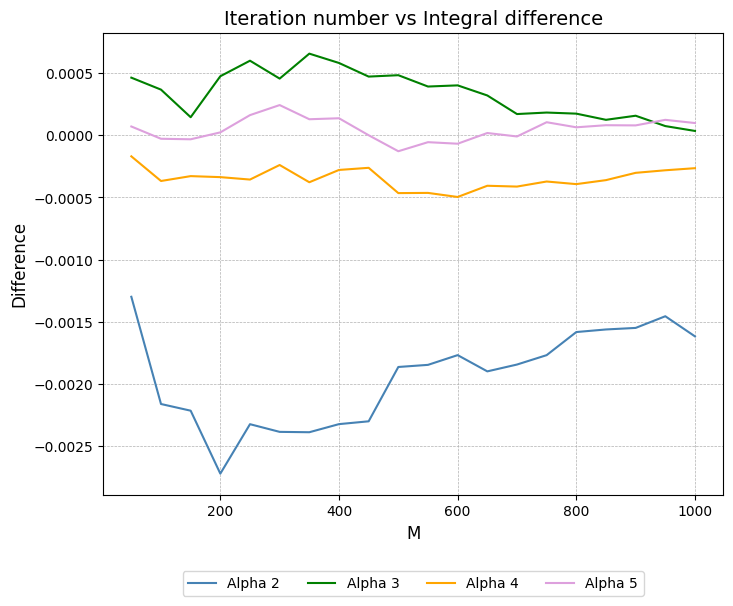

In [6]:
# data processing --> computing convergence
r_1 = [results_dict_ais_for['alpha_1'][i][1] - 1.99997e-1 for i in range(len(results_dict_ais_for['alpha_1']))]
r_2 = [results_dict_ais_for['alpha_2'][i][1] - 1.99997e-1 for i in range(len(results_dict_ais_for['alpha_1']))]
r_3 = [results_dict_ais_for['alpha_3'][i][1] - 1.99997e-1 for i in range(len(results_dict_ais_for['alpha_1']))]
r_4 = [results_dict_ais_for['alpha_4'][i][1] - 1.99997e-1 for i in range(len(results_dict_ais_for['alpha_1']))]
m = [results_dict_ais_for['alpha_1'][i][0] for i in range(len(results_dict_ais_for['alpha_1']))]

# plotting
plt.figure(figsize=(8, 6))  
plt.plot(m, r_1, label="Alpha 2",  color='steelblue')
plt.plot(m, r_2, label="Alpha 3",  color='green')
plt.plot(m, r_3, label="Alpha 4",  color='orange')
plt.plot(m, r_4, label="Alpha 5",  color='plum')

# adjusting plot layout
plt.xlabel('M', fontsize=12)
plt.ylabel('Difference', fontsize=12)
plt.title('Iteration number vs Integral difference', fontsize=14)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# showing plot
plt.show()

picking <span style="color:lightblue">sigma</span> and <span style="color:lightblue">M</span>.


In [7]:
# running AIS with the chosen alpha 

# defining parameters
alpha = np.array([1, 1, 1, 1, 1])           # Alpha for the target distribution
n = np.array([0, 0, 1, 0 ,0])               # Values for n
alpha_proposal = np.array([3, 3, 3, 3, 3])  # Alpha for the Dirichlet proposal (e.g., uniform)
num_samples = 1                             # Number of samples to draw
sigma = 500                                 # Set sigma value as needed

# defining ranges for eta and bigm checkpoints
eta_ranges = [np.linspace(0, 1, 10), np.linspace(0, 1, 100), np.linspace(0, 1, 500), np.linspace(0, 1, 1000)]
eta_part = [10, 100, 500, 1000]
bigm_checkpoints = list(range(100, 5100, 100))

# storing results for each bigm and eta combination
results_dict_ais_for_t = run_ais_back_experiment(  eta_ranges=eta_ranges, 
                                                    alpha=alpha, 
                                                    proposal_distribution=proposal_distribution, 
                                                    wrapped_log_objective_function=wrapped_log_objective_function, 
                                                    alpha_proposal=alpha_proposal, 
                                                    M=5000,
                                                    met_obj=mh.met, 
                                                    bigm_checkpoints=bigm_checkpoints, 
                                                    eta_part=eta_part,
                                                    init=True,
                                                )

Checkpoint reached: eta = 10, BigM = 100, mean_ratio = 0.18891695540783587
Checkpoint reached: eta = 10, BigM = 200, mean_ratio = 0.1938927431988649
Checkpoint reached: eta = 10, BigM = 300, mean_ratio = 0.19246563982746773
Checkpoint reached: eta = 10, BigM = 400, mean_ratio = 0.19483474583961555
Checkpoint reached: eta = 10, BigM = 500, mean_ratio = 0.19536039378738826
Checkpoint reached: eta = 10, BigM = 600, mean_ratio = 0.19612554892651693
Checkpoint reached: eta = 10, BigM = 700, mean_ratio = 0.1963690262109469
Checkpoint reached: eta = 10, BigM = 800, mean_ratio = 0.19690461368133974
Checkpoint reached: eta = 10, BigM = 900, mean_ratio = 0.19662850749953564
Checkpoint reached: eta = 10, BigM = 1000, mean_ratio = 0.19714036613742644
Checkpoint reached: eta = 10, BigM = 1100, mean_ratio = 0.19703737245206032
Checkpoint reached: eta = 10, BigM = 1200, mean_ratio = 0.19696190950438067
Checkpoint reached: eta = 10, BigM = 1300, mean_ratio = 0.19646054041203423
Checkpoint reached: eta

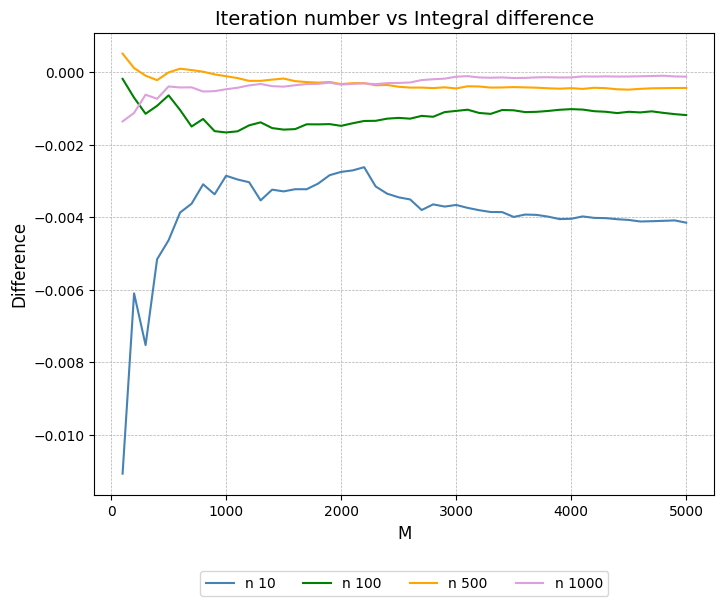

In [8]:
# data processing --> computing convergence
d_1 = [results_dict_ais_for_t[(i, 10)]['mean_ratio'] - 1.99997e-1 for i in list(range(100, 5100, 100))]
d_2 = [results_dict_ais_for_t[(i, 100)]['mean_ratio'] - 1.99997e-1 for i in list(range(100, 5100, 100))]
d_3 = [results_dict_ais_for_t[(i, 500)]['mean_ratio'] - 1.99997e-1 for i in list(range(100, 5100, 100))]
d_4 = [results_dict_ais_for_t[(i, 1000)]['mean_ratio'] - 1.99997e-1 for i in list(range(100, 5100, 100))]

# storing the selected ranges in a list
m = list(range(100, 5100, 100))

# plotting
plt.figure(figsize=(8, 6))                              
plt.plot(m, d_1, label="n 10",  color='steelblue')
plt.plot(m, d_2, label="n 100",  color='green')
plt.plot(m, d_3, label="n 500",  color='orange')
plt.plot(m, d_4, label="n 1000",  color='plum')

# adjusting plot layout
plt.xlabel('M', fontsize=12)
plt.ylabel('Difference', fontsize=12)
plt.title('Iteration number vs Integral difference', fontsize=14)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# showing plot
plt.show()

### AIS Backward

In [9]:
# definining parameters
alpha_proposals = [
    np.ones(5),           # Alpha proposal 1 (uniform at 1)
    np.full(5, 2),        # Alpha proposal 2 (uniform at 2)
    np.full(5, 3),        # Alpha proposal 3 (uniform at 3)
    np.full(5, 4),        # Alpha proposal 4 (uniform at 4)
    np.full(5, 5)         # Alpha proposal 5 (uniform at 5)
]
n = np.array([0, 0, 1, 0 ,0])                                                               # Values for n
eta = np.array([np.full(len(alpha_proposals[0]), eta) for eta in np.linspace(0, 1, 1000)])  # Eta values for the objective function
sigma = 500                                                                                 # Set sigma value as needed
bigm = 1000                                                                                 # Number of AIS iterations
interval = 50                                                                               # Compute mean every 50 iterations

# creating a dictionary to store the results for each alpha proposal
results_dict_ais_back = run_ais_for_alpha_proposals( alpha_proposals=alpha_proposals, 
                                                    proposal_distribution=proposal_distribution, 
                                                    wrapped_log_objective_function=wrapped_log_objective_function, 
                                                    eta=eta, 
                                                    met_obj=mh.met, 
                                                    M=bigm, 
                                                    interval=interval,
                                                    init=False, 
                                                )

Running AIS with alpha proposal 1: [1. 1. 1. 1. 1.]
Mean ratio after 50 iterations for alpha 1: 5.062647099598017
Mean ratio after 100 iterations for alpha 1: 5.079624737137078
Mean ratio after 150 iterations for alpha 1: 5.082829148727621
Mean ratio after 200 iterations for alpha 1: 5.051396485347893
Mean ratio after 250 iterations for alpha 1: 5.057970701622286
Mean ratio after 300 iterations for alpha 1: 5.064546778994361
Mean ratio after 350 iterations for alpha 1: 5.0530076115889795
Mean ratio after 400 iterations for alpha 1: 5.048758625493754
Mean ratio after 450 iterations for alpha 1: 5.03976625198814
Mean ratio after 500 iterations for alpha 1: 5.038401869708618
Mean ratio after 550 iterations for alpha 1: 5.034360382949979
Mean ratio after 600 iterations for alpha 1: 5.041590112330738
Mean ratio after 650 iterations for alpha 1: 5.03851443807477
Mean ratio after 700 iterations for alpha 1: 5.041775419611326
Mean ratio after 750 iterations for alpha 1: 5.041683682246635
Mean 

#### parameter tuning

selecting <span style="color:lightblue"> alpha </span>.

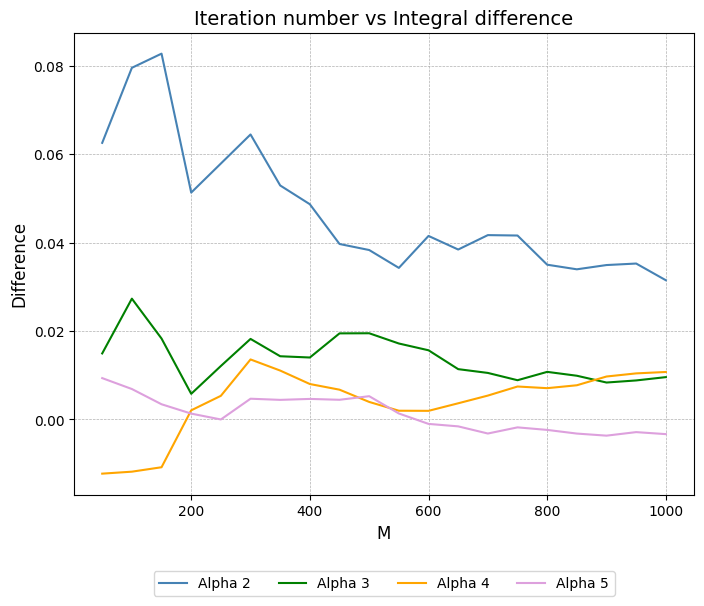

In [10]:
# data processing --> computing convergence
r_1 = [results_dict_ais_back['alpha_1'][i][1] - 5.000075 for i in range(len(results_dict_ais_for['alpha_1']))]
r_2 = [results_dict_ais_back['alpha_2'][i][1] - 5.000075 for i in range(len(results_dict_ais_for['alpha_1']))]
r_3 = [results_dict_ais_back['alpha_3'][i][1] - 5.000075 for i in range(len(results_dict_ais_for['alpha_1']))]
r_4 = [results_dict_ais_back['alpha_4'][i][1] - 5.000075 for i in range(len(results_dict_ais_for['alpha_1']))]
m = [results_dict_ais_back['alpha_1'][i][0] for i in range(len(results_dict_ais_for['alpha_1']))]

# plotting
plt.figure(figsize=(8, 6))  
plt.plot(m, r_1, label="Alpha 2",  color='steelblue')
plt.plot(m, r_2, label="Alpha 3",  color='green')
plt.plot(m, r_3, label="Alpha 4",  color='orange')
plt.plot(m, r_4, label="Alpha 5",  color='plum')

# adjusting plot layout
plt.xlabel('M', fontsize=12)
plt.ylabel('Difference', fontsize=12)
plt.title('Iteration number vs Integral difference', fontsize=14)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# showing plot
plt.show()

selecting <span style="color:lightblue"> sigma </span> and <span style="color:lightblue"> M </span>.

In [11]:
# defining parameters
alpha = np.array([1, 1, 1, 1, 1])           # Alpha for the target distribution
n = np.array([0, 0, 1, 0 ,0])               # Values for n
alpha_proposal = np.array([3, 3, 3, 3, 3])  # Alpha for the Dirichlet proposal (e.g., uniform)
num_samples = 1                             # Number of samples to draw
sigma = 500                                 # Set sigma value as needed

# defining ranges for eta and bigm checkpoints
eta_ranges = [np.linspace(0, 1, 10), np.linspace(0, 1, 100), np.linspace(0, 1, 500), np.linspace(0, 1, 1000)]
eta_part = [10, 100, 500, 1000]
bigm_checkpoints = list(range(100, 5100, 100))

# creating a dictionary to store results for each bigm and eta combination
results_dict_ais_back_t = run_ais_back_experiment(  eta_ranges=eta_ranges, 
                                                    alpha=alpha, 
                                                    proposal_distribution=proposal_distribution, 
                                                    wrapped_log_objective_function=wrapped_log_objective_function, 
                                                    alpha_proposal=alpha_proposal, 
                                                    M=5000,
                                                    met_obj=mh.met, 
                                                    bigm_checkpoints=bigm_checkpoints, 
                                                    eta_part=eta_part,
                                                    init=False,
                                                )

Checkpoint reached: eta = 10, BigM = 100, mean_ratio = 5.373931355341631
Checkpoint reached: eta = 10, BigM = 200, mean_ratio = 5.283167511335446
Checkpoint reached: eta = 10, BigM = 300, mean_ratio = 5.265780577566586
Checkpoint reached: eta = 10, BigM = 400, mean_ratio = 5.282000671275086
Checkpoint reached: eta = 10, BigM = 500, mean_ratio = 5.255659934090966
Checkpoint reached: eta = 10, BigM = 600, mean_ratio = 5.289223173792658
Checkpoint reached: eta = 10, BigM = 700, mean_ratio = 5.284860448735969
Checkpoint reached: eta = 10, BigM = 800, mean_ratio = 5.278369904357692
Checkpoint reached: eta = 10, BigM = 900, mean_ratio = 5.2758371470704635
Checkpoint reached: eta = 10, BigM = 1000, mean_ratio = 5.272191706458342
Checkpoint reached: eta = 10, BigM = 1100, mean_ratio = 5.2774683163604275
Checkpoint reached: eta = 10, BigM = 1200, mean_ratio = 5.283524531426408
Checkpoint reached: eta = 10, BigM = 1300, mean_ratio = 5.281995634429557
Checkpoint reached: eta = 10, BigM = 1400, me

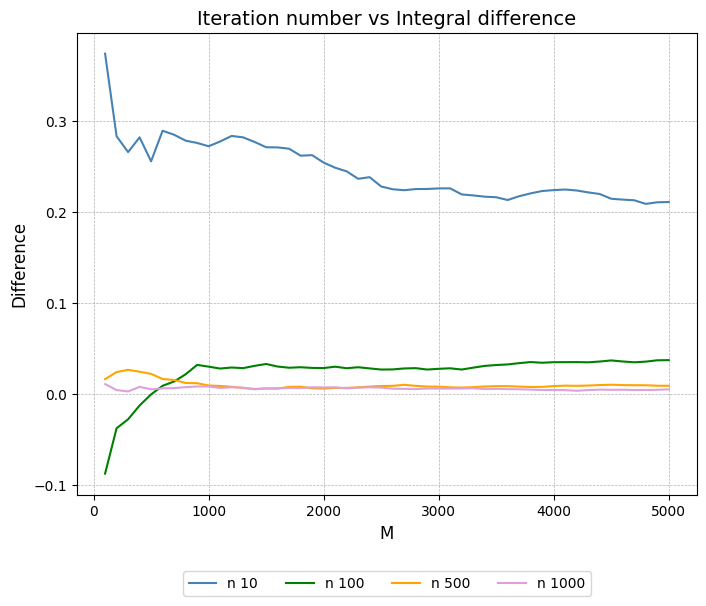

In [12]:
# data processing --> computing convergence
d_1 = [results_dict_ais_back_t[(i, 10)]['mean_ratio'] - 5.000075 for i in list(range(100, 5100, 100))]
d_2 = [results_dict_ais_back_t[(i, 100)]['mean_ratio'] - 5.000075 for i in list(range(100, 5100, 100))]
d_3 = [results_dict_ais_back_t[(i, 500)]['mean_ratio'] - 5.000075 for i in list(range(100, 5100, 100))]
d_4 = [results_dict_ais_back_t[(i, 1000)]['mean_ratio'] - 5.000075 for i in list(range(100, 5100, 100))]

# creating a list for ranges
m = list(range(100, 5100, 100))

# plotting
plt.figure(figsize=(8, 6))                   
plt.plot(m, d_1, label="n 10",  color='steelblue')
plt.plot(m, d_2, label="n 100",  color='green')
plt.plot(m, d_3, label="n 500",  color='orange')
plt.plot(m, d_4, label="n 1000",  color='plum')

# adjsuting plot layout 
plt.xlabel('M', fontsize=12)
plt.ylabel('Difference', fontsize=12)
plt.title('Iteration number vs Integral difference', fontsize=14) 
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# showing plot
plt.show()

### LIS Forward Geometric

In [13]:
# defining parameters
alpha_proposals = [
    np.ones(5),           # Alpha proposal 1 (uniform at 1)
    np.full(5, 2),        # Alpha proposal 2 (uniform at 2)
    np.full(5, 3),        # Alpha proposal 3 (uniform at 3)
    np.full(5, 4),        # Alpha proposal 4 (uniform at 4)
    np.full(5, 5)         # Alpha proposal 5 (uniform at 5)
]

n = np.array([0, 0, 1, 0 ,0])                                                               # Values for n
eta = np.array([np.full(len(alpha_proposals[0]), eta) for eta in np.linspace(0, 1, 1000)])  # Eta values for the objective function
sigma = 500                                                                                 # Set sigma value as needed
bigm = 10                                                                                   # Number of AIS iterations
interval = 1                                                                                # Compute mean every 50 iterations
stepsize = [1]
init=True                                                                                    # flag


# creating a dictionary to store the results for each alpha proposal
results_dict_lis_for_geom = run_lis_for_alpha_proposals(alpha_proposals=alpha_proposals,
                                                        wrapped_log_objective_function=wrapped_log_objective_function,
                                                        proposal_distribution= proposal_distribution,
                                                        eta=eta,
                                                        M=bigm,
                                                        met_obj=mh.met,
                                                        stepsize=stepsize,
                                                        interval=interval,
                                                        init=True,
                                                        rho0=0.5,
                                                        rho1=0.5)

Running LIS 1: [1. 1. 1. 1. 1.]
Mean ratio after 1 iterations for alpha 1: 0.20543769069868484
Mean ratio after 2 iterations for alpha 1: 0.20713071970002966
Mean ratio after 3 iterations for alpha 1: 0.2060082017912617
Mean ratio after 4 iterations for alpha 1: 0.20433174931270054
Mean ratio after 5 iterations for alpha 1: 0.202886146485782
Mean ratio after 6 iterations for alpha 1: 0.20341317193682562
Mean ratio after 7 iterations for alpha 1: 0.20321125628529604
Mean ratio after 8 iterations for alpha 1: 0.20255700788819314
Mean ratio after 9 iterations for alpha 1: 0.20274557307449767
Mean ratio after 10 iterations for alpha 1: 0.20352667862113724
Final mean ratio for alpha 1 after 10 iterations: 0.20352667862113724
Running LIS 2: [2 2 2 2 2]
Mean ratio after 1 iterations for alpha 2: 0.20105521837134743
Mean ratio after 2 iterations for alpha 2: 0.20035599978812857
Mean ratio after 3 iterations for alpha 2: 0.2003057842607825
Mean ratio after 4 iterations for alpha 2: 0.2005485574

#### Paramater tuning

selecting <span style="color:lightblue"> alpha </span>.

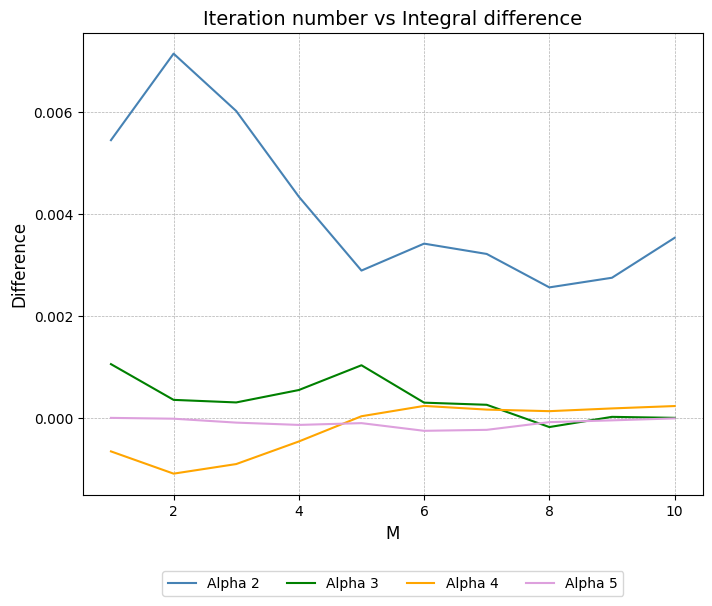

In [14]:
# data processing --> computing convergence
r_1 = [results_dict_lis_for_geom['alpha_1'][i][1] - 1.99997e-1 for i in range(len(results_dict_lis_for_geom['alpha_1']))]
r_2 = [results_dict_lis_for_geom['alpha_2'][i][1] - 1.99997e-1 for i in range(len(results_dict_lis_for_geom['alpha_1']))]
r_3 = [results_dict_lis_for_geom['alpha_3'][i][1] - 1.99997e-1 for i in range(len(results_dict_lis_for_geom['alpha_1']))]
r_4 = [results_dict_lis_for_geom['alpha_4'][i][1] - 1.99997e-1 for i in range(len(results_dict_lis_for_geom['alpha_1']))]
m = [results_dict_lis_for_geom['alpha_1'][i][0] for i in range(len(results_dict_lis_for_geom['alpha_1']))]

# plotting
plt.figure(figsize=(8, 6))  # Adjust figure size
plt.plot(m, r_1, label="Alpha 2",  color='steelblue')
plt.plot(m, r_2, label="Alpha 3",  color='green')
plt.plot(m, r_3, label="Alpha 4",  color='orange')
plt.plot(m, r_4, label="Alpha 5",  color='plum')

# adjusting plot layout
plt.xlabel('M', fontsize=12)
plt.ylabel('Difference', fontsize=12)
plt.title('Iteration number vs Integral difference', fontsize=14)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# showing plot
plt.show()

selecting <span style="color:lightblue"> sigma </span> and<span style="color:lightblue"> M </span> .

In [15]:
# defining parameters
alpha = np.array([1, 1, 1, 1, 1])           # Alpha for the target distribution
n = np.array([0, 0, 1, 0 ,0])               # Values for n
alpha_proposal = np.array([4, 4, 4, 4, 4])  # Alpha for the Dirichlet proposal (e.g., uniform)
num_samples = 10                            # Number of samples to draw
sigma = 500                                 # Set sigma value as needed

# defining ranges for eta and bigm checkpoints
eta_ranges = [np.linspace(0, 1, 10), np.linspace(0, 1, 100), np.linspace(0, 1, 500), np.linspace(0, 1, 1000)]
eta_part = [10, 100, 500, 1000]
bigm_checkpoints = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

# dictionary to store results for each bigm and eta combination
results_dict_lis_for_geom_t = run_lis_experiment(eta_ranges=eta_ranges,
                                                 alpha=alpha,
                                                 proposal_distribution=proposal_distribution,
                                                 wrapped_log_objective_function=wrapped_log_objective_function,
                                                 alpha_proposal=alpha_proposal,
                                                 met_obj=mh.met,
                                                 stepsize=stepsize,
                                                 M=bigm,
                                                 bigm_checkpoints=bigm_checkpoints,
                                                 eta_part=eta_part,
                                                 init=True,
                                                 rho0=0.5,
                                                rho1=0.5)

Checkpoint reached: eta = 10, BigM = 1, mean_ratio = 0.2006721676676031
Checkpoint reached: eta = 10, BigM = 2, mean_ratio = 0.2043644979501777
Checkpoint reached: eta = 10, BigM = 3, mean_ratio = 0.20699068471327586
Checkpoint reached: eta = 10, BigM = 4, mean_ratio = 0.20680725133477906
Checkpoint reached: eta = 10, BigM = 5, mean_ratio = 0.20437632645819187
Checkpoint reached: eta = 10, BigM = 6, mean_ratio = 0.2049450224978988
Checkpoint reached: eta = 10, BigM = 7, mean_ratio = 0.20451014087372307
Checkpoint reached: eta = 10, BigM = 8, mean_ratio = 0.20585126847821955
Checkpoint reached: eta = 10, BigM = 9, mean_ratio = 0.20492218484154154
Checkpoint reached: eta = 10, BigM = 10, mean_ratio = 0.20337665180194672
Checkpoint reached: eta = 100, BigM = 1, mean_ratio = 0.20019192419542575
Checkpoint reached: eta = 100, BigM = 2, mean_ratio = 0.20438396052355007
Checkpoint reached: eta = 100, BigM = 3, mean_ratio = 0.2032572258050511
Checkpoint reached: eta = 100, BigM = 4, mean_ratio

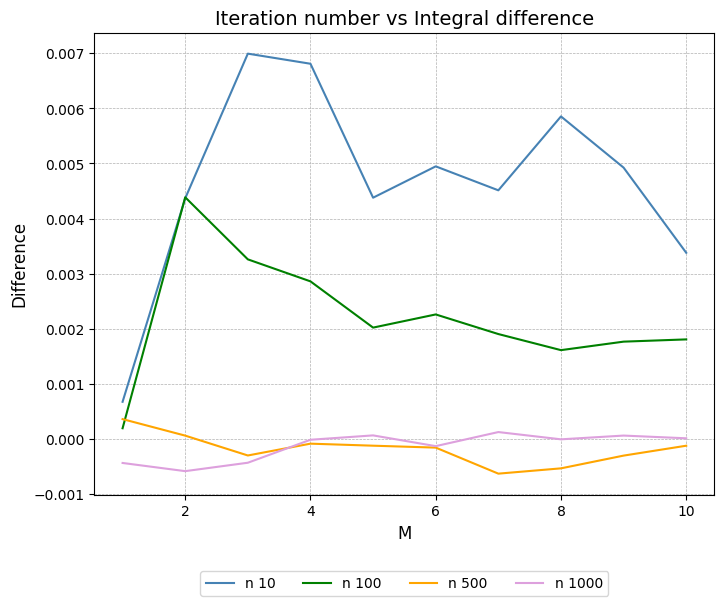

In [16]:
# data processing --> computing convergence
d_1 = [results_dict_lis_for_geom_t[(i, 10)]['mean_ratio'] - 1.99997e-1 for i in list(range(1, 11, 1))]
d_2 = [results_dict_lis_for_geom_t[(i, 100)]['mean_ratio'] - 1.99997e-1 for i in list(range(1, 11, 1))]
d_3 = [results_dict_lis_for_geom_t[(i, 500)]['mean_ratio'] - 1.99997e-1 for i in list(range(1, 11, 1))]
d_4 = [results_dict_lis_for_geom_t[(i, 1000)]['mean_ratio'] - 1.99997e-1 for i in list(range(1, 11, 1))]

# creating a list to store variable
m = list(range(1, 11, 1))

# Plotting
plt.figure(figsize=(8, 6))  
plt.plot(m, d_1, label="n 10",  color='steelblue')
plt.plot(m, d_2, label="n 100",  color='green')
plt.plot(m, d_3, label="n 500",  color='orange')
plt.plot(m, d_4, label="n 1000",  color='plum')

# adjusting the plot layout
plt.xlabel('M', fontsize=12)
plt.ylabel('Difference', fontsize=12)
plt.title('Iteration number vs Integral difference', fontsize=14)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# showing plot
plt.show()

### LIS Backward Geometric

In [17]:
# defining parameters
alpha_proposals = [
    np.ones(5),           # Alpha proposal 1 (uniform at 1)
    np.full(5, 2),        # Alpha proposal 2 (uniform at 2)
    np.full(5, 3),        # Alpha proposal 3 (uniform at 3)
    np.full(5, 4),        # Alpha proposal 4 (uniform at 4)
    np.full(5, 5)         # Alpha proposal 5 (uniform at 5)
]

n = np.array([0, 0, 1, 0 ,0])                                                               # Values for n
eta = np.array([np.full(len(alpha_proposals[0]), eta) for eta in np.linspace(0, 1, 1000)])  # Eta values for the objective function
sigma = 500                                                                                 # Set sigma value as needed
bigm = 10                                                                                   # Number of AIS iterations
interval = 1                                                                                # Compute mean every 50 iterations
stepsize = [1]

# creating a dictionary to store the results for each alpha proposal
results_dict_lis_back_geom = run_lis_for_alpha_proposals(alpha_proposals=alpha_proposals, 
                                                        proposal_distribution=proposal_distribution, 
                                                        wrapped_log_objective_function=wrapped_log_objective_function, 
                                                        eta=eta, 
                                                        met_obj=mh.met, 
                                                        stepsize=stepsize, 
                                                        M=bigm, 
                                                        interval=interval,
                                                        init=False,
                                                    )

Running LIS 1: [1. 1. 1. 1. 1.]
Mean ratio after 1 iterations for alpha 1: 4.957639910601426
Mean ratio after 2 iterations for alpha 1: 5.08099701030854
Mean ratio after 3 iterations for alpha 1: 5.057274975447833
Mean ratio after 4 iterations for alpha 1: 5.026247538490266
Mean ratio after 5 iterations for alpha 1: 5.020966182119734
Mean ratio after 6 iterations for alpha 1: 5.008164345189212
Mean ratio after 7 iterations for alpha 1: 5.013112932869924
Mean ratio after 8 iterations for alpha 1: 4.987863667997928
Mean ratio after 9 iterations for alpha 1: 4.990755012639814
Mean ratio after 10 iterations for alpha 1: 4.9964917717019715
Final mean ratio for alpha 1 after 10 iterations: 4.9964917717019715
Running LIS 2: [2 2 2 2 2]
Mean ratio after 1 iterations for alpha 2: 5.068068870001545
Mean ratio after 2 iterations for alpha 2: 5.013198204499284
Mean ratio after 3 iterations for alpha 2: 5.0261633129498255
Mean ratio after 4 iterations for alpha 2: 5.013527020464375
Mean ratio after

#### Parameters tuning

selecting <span style="color:lightblue"> alpha </span>.

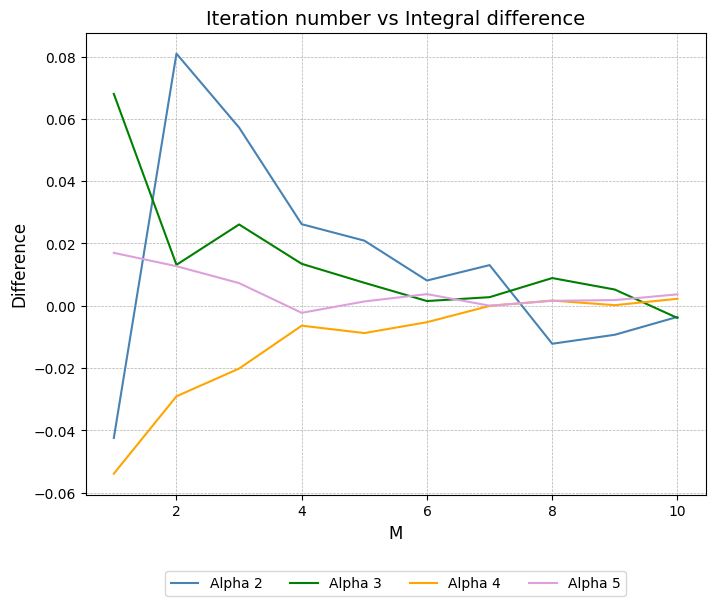

In [18]:
# data processing --> computing convergence
r_1 = [results_dict_lis_back_geom['alpha_1'][i][1] - 5.000075 for i in range(len(results_dict_lis_back_geom['alpha_1']))]
r_2 = [results_dict_lis_back_geom['alpha_2'][i][1] - 5.000075 for i in range(len(results_dict_lis_back_geom['alpha_1']))]
r_3 = [results_dict_lis_back_geom['alpha_3'][i][1] - 5.000075 for i in range(len(results_dict_lis_back_geom['alpha_1']))]
r_4 = [results_dict_lis_back_geom['alpha_4'][i][1] - 5.000075 for i in range(len(results_dict_lis_back_geom['alpha_1']))]
m = [results_dict_lis_back_geom['alpha_1'][i][0] for i in range(len(results_dict_lis_back_geom['alpha_1']))]

# plotting
plt.figure(figsize=(8, 6))  # Adjust figure size
plt.plot(m, r_1, label="Alpha 2",  color='steelblue')
plt.plot(m, r_2, label="Alpha 3",  color='green')
plt.plot(m, r_3, label="Alpha 4",  color='orange')
plt.plot(m, r_4, label="Alpha 5",  color='plum')

# adjusting plot layout
plt.xlabel('M', fontsize=12)
plt.ylabel('Difference', fontsize=12)
plt.title('Iteration number vs Integral difference', fontsize=14)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# showing plot
plt.show()

selecting <span style="color:lightblue"> sigma </span> and<span style="color:lightblue"> M </span> .

In [19]:
# defining the parameters
alpha = np.array([1, 1, 1, 1, 1])           # Alpha for the target distribution
n = np.array([0, 0, 1, 0 ,0])               # Values for n
alpha_proposal = np.array([3, 3, 3, 3, 3])  # Alpha for the Dirichlet proposal (e.g., uniform)
num_samples = 10                            # Number of samples to draw
sigma = 500                                 # Set sigma value as needed

# defining ranges for eta and bigm checkpoints
eta_ranges = [np.linspace(0, 1, 10), np.linspace(0, 1, 100), np.linspace(0, 1, 500), np.linspace(0, 1, 1000)]
eta_part = [10, 100, 500, 1000]
bigm_checkpoints = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

# Dictionary to store results for each bigm and eta combination
results_dict_lis_back_geom_t = run_lis_experiment(eta_ranges=eta_ranges,
                                                 alpha=alpha,
                                                 proposal_distribution=proposal_distribution,
                                                 wrapped_log_objective_function=wrapped_log_objective_function,
                                                 alpha_proposal=alpha_proposal,
                                                 met_obj=mh.met,
                                                 M=10,
                                                 stepsize=stepsize,
                                                 bigm_checkpoints=bigm_checkpoints,
                                                 eta_part=eta_part,
                                                 init=False)

Checkpoint reached: eta = 10, BigM = 1, mean_ratio = 4.824806570814253
Checkpoint reached: eta = 10, BigM = 2, mean_ratio = 4.925086793225261
Checkpoint reached: eta = 10, BigM = 3, mean_ratio = 4.8992850306115505
Checkpoint reached: eta = 10, BigM = 4, mean_ratio = 4.935258595465614
Checkpoint reached: eta = 10, BigM = 5, mean_ratio = 4.9029554664304325
Checkpoint reached: eta = 10, BigM = 6, mean_ratio = 4.8692811010669965
Checkpoint reached: eta = 10, BigM = 7, mean_ratio = 4.89840765345171
Checkpoint reached: eta = 10, BigM = 8, mean_ratio = 4.890293695440295
Checkpoint reached: eta = 10, BigM = 9, mean_ratio = 4.8784503229440155
Checkpoint reached: eta = 10, BigM = 10, mean_ratio = 4.898147048268865
Checkpoint reached: eta = 100, BigM = 1, mean_ratio = 4.967405936396515
Checkpoint reached: eta = 100, BigM = 2, mean_ratio = 4.963517416297513
Checkpoint reached: eta = 100, BigM = 3, mean_ratio = 4.994194630487897
Checkpoint reached: eta = 100, BigM = 4, mean_ratio = 5.01378040596017

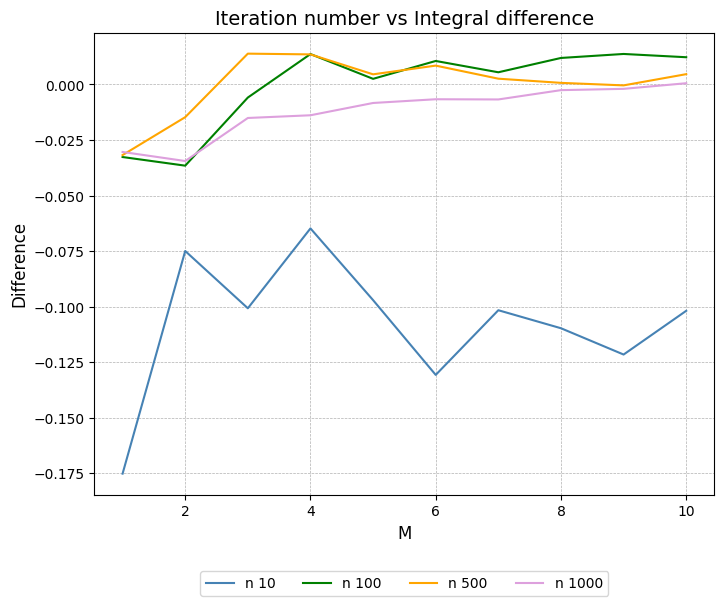

In [20]:
# data processing --> computing convergence
d_1 = [results_dict_lis_back_geom_t[(i, 10)]['mean_ratio'] - 5.000075 for i in list(range(1, 11, 1))]
d_2 = [results_dict_lis_back_geom_t[(i, 100)]['mean_ratio'] - 5.000075 for i in list(range(1, 11, 1))]
d_3 = [results_dict_lis_back_geom_t[(i, 500)]['mean_ratio'] - 5.000075 for i in list(range(1, 11, 1))]
d_4 = [results_dict_lis_back_geom_t[(i, 1000)]['mean_ratio'] - 5.000075 for i in list(range(1, 11, 1))]

# storing list range
m = list(range(1, 11, 1))

# plotting
plt.figure(figsize=(8, 6))  # Adjust figure size
plt.plot(m, d_1, label="n 10",  color='steelblue')
plt.plot(m, d_2, label="n 100",  color='green')
plt.plot(m, d_3, label="n 500",  color='orange')
plt.plot(m, d_4, label="n 1000",  color='plum')

# adjusting plot layout
plt.xlabel('M', fontsize=12)
plt.ylabel('Difference', fontsize=12)
plt.title('Iteration number vs Integral difference', fontsize=14)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# showing plot
plt.show()

### LIS Forward Optimal

In [21]:
# defining parameters
alpha_proposals = [
    np.ones(5),           # Alpha proposal 1 (uniform at 1)
    np.full(5, 2),        # Alpha proposal 2 (uniform at 2)
    np.full(5, 3),        # Alpha proposal 3 (uniform at 3)
    np.full(5, 4),        # Alpha proposal 4 (uniform at 4)
    np.full(5, 5)         # Alpha proposal 5 (uniform at 5)
]

n = np.array([0, 0, 1, 0 ,0])                                                               # Values for n
eta = np.array([np.full(len(alpha_proposals[0]), eta) for eta in np.linspace(0, 1, 1000)])  # Eta values for the objective function
sigma = 500                                                                                 # Set sigma value as needed
bigm = 10                                                                                   # Number of AIS iterations
interval = 1                                                                                # Compute mean every 50 iterations
stepsize = [1]

# creating a dictionary to store the results for each alpha proposal
results_dict_lis_for_opt = run_lis_for_alpha_proposals(alpha_proposals=alpha_proposals, 
                                                        proposal_distribution=proposal_distribution, 
                                                        wrapped_log_objective_function=wrapped_log_objective_function, 
                                                        eta=eta, 
                                                        met_obj=mh.met, 
                                                        stepsize=stepsize, 
                                                        M=bigm, 
                                                        interval=interval,
                                                        init=True,
                                                        iratios=0.2
                                                    )

Running LIS 1: [1. 1. 1. 1. 1.]


/Users/jacopotarantino/Documents/Documents /thesis_uni/thesis_draft_tarantino/methods.py:474: RuntimeWarning: divide by zero encountered in log
  lr[j] = lpr1.item() - log_add_exp(iratios[i] + np.log(prev_n_trans / this_n_trans) + lpr0, lpr1)
/Users/jacopotarantino/Documents/Documents /thesis_uni/thesis_draft_tarantino/methods.py:502: RuntimeWarning: divide by zero encountered in log
  lr[j] = lpr0.item() - log_add_exp(iratios[i] + np.log(prev_n_trans / this_n_trans) + lpr0, lpr1)


Mean ratio after 1 iterations for alpha 1: 0.20580722900726525
Mean ratio after 2 iterations for alpha 1: 0.20232313310541838
Mean ratio after 3 iterations for alpha 1: 0.20135869622039457
Mean ratio after 4 iterations for alpha 1: 0.20010269209238682
Mean ratio after 5 iterations for alpha 1: 0.20066438024514274
Mean ratio after 6 iterations for alpha 1: 0.20057326462332167
Mean ratio after 7 iterations for alpha 1: 0.200501918750789
Mean ratio after 8 iterations for alpha 1: 0.19990048337652522
Mean ratio after 9 iterations for alpha 1: 0.19925860099478712
Mean ratio after 10 iterations for alpha 1: 0.19967976712892177
Final mean ratio for alpha 1 after 10 iterations: 0.19967976712892177
Running LIS 2: [2 2 2 2 2]
Mean ratio after 1 iterations for alpha 2: 0.19839030134454858
Mean ratio after 2 iterations for alpha 2: 0.19961009498339327
Mean ratio after 3 iterations for alpha 2: 0.19996965489803661
Mean ratio after 4 iterations for alpha 2: 0.1999973837819966
Mean ratio after 5 iter

#### Parameter Tuning

selecting <span style="color:lightblue"> alpha </span>.

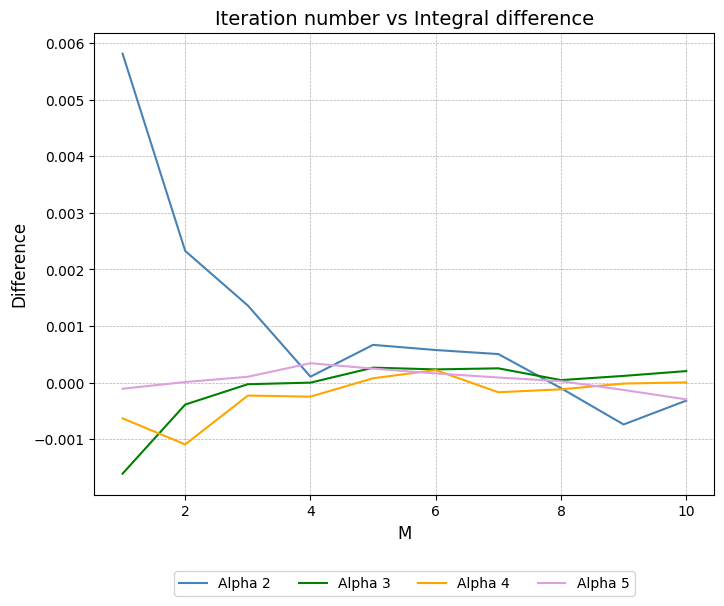

In [22]:
# data processing --> computing convergence
r_1 = [results_dict_lis_for_opt['alpha_1'][i][1] - 1.99997e-1 for i in range(len(results_dict_lis_for_opt['alpha_1']))]
r_2 = [results_dict_lis_for_opt['alpha_2'][i][1] - 1.99997e-1 for i in range(len(results_dict_lis_for_opt['alpha_1']))]
r_3 = [results_dict_lis_for_opt['alpha_3'][i][1] - 1.99997e-1 for i in range(len(results_dict_lis_for_opt['alpha_1']))]
r_4 = [results_dict_lis_for_opt['alpha_4'][i][1] - 1.99997e-1 for i in range(len(results_dict_lis_for_opt['alpha_1']))]
m = [results_dict_lis_for_opt['alpha_1'][i][0] for i in range(len(results_dict_lis_for_opt['alpha_1']))]

# plotting
plt.figure(figsize=(8, 6))  # Adjust figure size
plt.plot(m, r_1, label="Alpha 2",  color='steelblue')
plt.plot(m, r_2, label="Alpha 3",  color='green')
plt.plot(m, r_3, label="Alpha 4",  color='orange')
plt.plot(m, r_4, label="Alpha 5",  color='plum')

# adjusting plot layout
plt.xlabel('M', fontsize=12)
plt.ylabel('Difference', fontsize=12)
plt.title('Iteration number vs Integral difference', fontsize=14)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# showing plot
plt.show()

selecting <span style="color:lightblue"> sigma </span> and<span style="color:lightblue"> M </span> .

In [23]:
# defining parameters
alpha = np.array([1, 1, 1, 1, 1])           # Alpha for the target distribution
n = np.array([0, 0, 1, 0 ,0])               # Values for n
alpha_proposal = np.array([4, 4, 4, 4, 4])  # Alpha for the Dirichlet proposal (e.g., uniform)
num_samples = 10                            # Number of samples to draw
sigma = 500                                 # Set sigma value as needed

# defining ranges for eta and bigm checkpoints
eta_ranges = [np.linspace(0, 1, 10), np.linspace(0, 1, 100), np.linspace(0, 1, 500), np.linspace(0, 1, 1000)]
eta_part = [10, 100, 500, 1000]
bigm_checkpoints = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

# dictionary to store results for each bigm and eta combination
results_dict_lis_for_opt_t = run_lis_experiment(eta_ranges=eta_ranges,
                                                 alpha=alpha,
                                                 proposal_distribution=proposal_distribution,
                                                 wrapped_log_objective_function=wrapped_log_objective_function,
                                                 alpha_proposal=alpha_proposal,
                                                 met_obj=mh.met,
                                                 M=10,
                                                 stepsize=stepsize,
                                                 bigm_checkpoints=bigm_checkpoints,
                                                 eta_part=eta_part,
                                                 init=True,
                                                 iratios=0.2)

Checkpoint reached: eta = 10, BigM = 1, mean_ratio = 0.20148135791479302
Checkpoint reached: eta = 10, BigM = 2, mean_ratio = 0.20111368527217427
Checkpoint reached: eta = 10, BigM = 3, mean_ratio = 0.20039476079688823
Checkpoint reached: eta = 10, BigM = 4, mean_ratio = 0.2007404016713082
Checkpoint reached: eta = 10, BigM = 5, mean_ratio = 0.2018438331395472
Checkpoint reached: eta = 10, BigM = 6, mean_ratio = 0.20290086732827473
Checkpoint reached: eta = 10, BigM = 7, mean_ratio = 0.2025462900019624
Checkpoint reached: eta = 10, BigM = 8, mean_ratio = 0.20480816529269824
Checkpoint reached: eta = 10, BigM = 9, mean_ratio = 0.2028993522999166
Checkpoint reached: eta = 10, BigM = 10, mean_ratio = 0.20233297929743482
Checkpoint reached: eta = 100, BigM = 1, mean_ratio = 0.2013930464476161
Checkpoint reached: eta = 100, BigM = 2, mean_ratio = 0.20299937743999857
Checkpoint reached: eta = 100, BigM = 3, mean_ratio = 0.2026315933084478
Checkpoint reached: eta = 100, BigM = 4, mean_ratio =

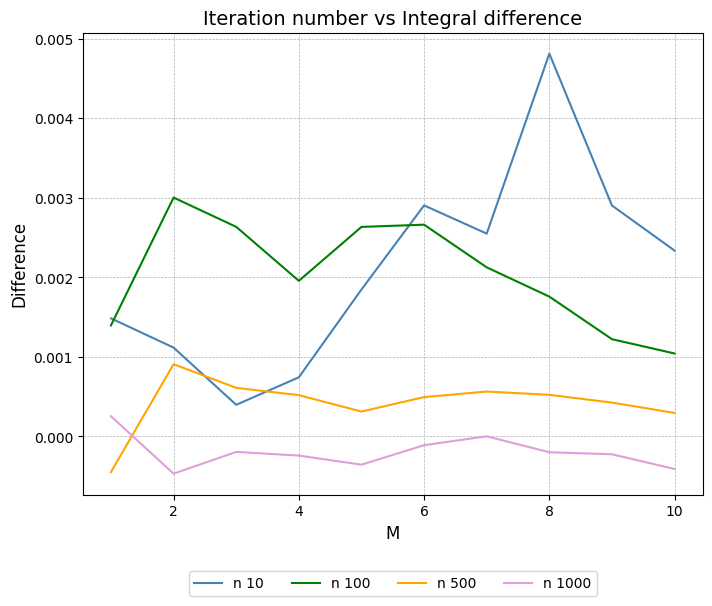

In [24]:
# data processing --> computing convergence
d_1 = [results_dict_lis_for_opt_t[(i, 10)]['mean_ratio'] - 1.99997e-1 for i in list(range(1, 11, 1))]
d_2 = [results_dict_lis_for_opt_t[(i, 100)]['mean_ratio'] - 1.99997e-1 for i in list(range(1, 11, 1))]
d_3 = [results_dict_lis_for_opt_t[(i, 500)]['mean_ratio'] - 1.99997e-1 for i in list(range(1, 11, 1))]
d_4 = [results_dict_lis_for_opt_t[(i, 1000)]['mean_ratio'] - 1.99997e-1 for i in list(range(1, 11, 1))]

# creating a list for ranges
m = list(range(1, 11, 1))

# plotting
plt.figure(figsize=(8, 6))  # Adjust figure size
plt.plot(m, d_1, label="n 10",  color='steelblue')
plt.plot(m, d_2, label="n 100",  color='green')
plt.plot(m, d_3, label="n 500",  color='orange')
plt.plot(m, d_4, label="n 1000",  color='plum')

# adjusting the plot layout
plt.xlabel('M', fontsize=12)
plt.ylabel('Difference', fontsize=12)
plt.title('Iteration number vs Integral difference', fontsize=14)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# showing the  plot
plt.show()

### LIS Backward Optimal

In [25]:
# Define parameters
alpha_proposals = [
    np.ones(5),           # Alpha proposal 1 (uniform at 1)
    np.full(5, 2),        # Alpha proposal 2 (uniform at 2)
    np.full(5, 3),        # Alpha proposal 3 (uniform at 3)
    np.full(5, 4),        # Alpha proposal 4 (uniform at 4)
    np.full(5, 5)         # Alpha proposal 5 (uniform at 5)
]

n = np.array([0, 0, 1, 0 ,0])          # Values for n
eta = np.array([np.full(len(alpha_proposals[0]), eta) for eta in np.linspace(0, 1, 1000)])  # Eta values for the objective function
sigma = 500                             # Set sigma value as needed
bigm = 10                             # Number of AIS iterations
interval = 1                           # Compute mean every 50 iterations
stepsize = [1]

# Creating a dictionary to store the results for each alpha proposal
results_dict_lis_back_opt = run_lis_for_alpha_proposals(alpha_proposals=alpha_proposals, 
                                                        proposal_distribution=proposal_distribution, 
                                                        wrapped_log_objective_function=wrapped_log_objective_function, 
                                                        eta=eta, 
                                                        met_obj=mh.met, 
                                                        stepsize=stepsize, 
                                                        M=bigm, 
                                                        interval=interval,
                                                        init=False,
                                                        iratios=0.2
                                                    )

Running LIS 1: [1. 1. 1. 1. 1.]
Mean ratio after 1 iterations for alpha 1: 4.9388935419129965
Mean ratio after 2 iterations for alpha 1: 4.990488219366036
Mean ratio after 3 iterations for alpha 1: 5.0240490802973214
Mean ratio after 4 iterations for alpha 1: 5.04634205377572
Mean ratio after 5 iterations for alpha 1: 5.025779973879533
Mean ratio after 6 iterations for alpha 1: 5.040284992107601
Mean ratio after 7 iterations for alpha 1: 5.019352476734234
Mean ratio after 8 iterations for alpha 1: 5.008749923149191
Mean ratio after 9 iterations for alpha 1: 5.011873942068689
Mean ratio after 10 iterations for alpha 1: 5.006114902265963
Final mean ratio for alpha 1 after 10 iterations: 5.006114902265963
Running LIS 2: [2 2 2 2 2]
Mean ratio after 1 iterations for alpha 2: 5.037383260404705
Mean ratio after 2 iterations for alpha 2: 5.030162158795177
Mean ratio after 3 iterations for alpha 2: 5.025753466804719
Mean ratio after 4 iterations for alpha 2: 5.012212806270858
Mean ratio after 

#### Parameter tuning

selecting <span style="color:lightblue"> alpha </span>.

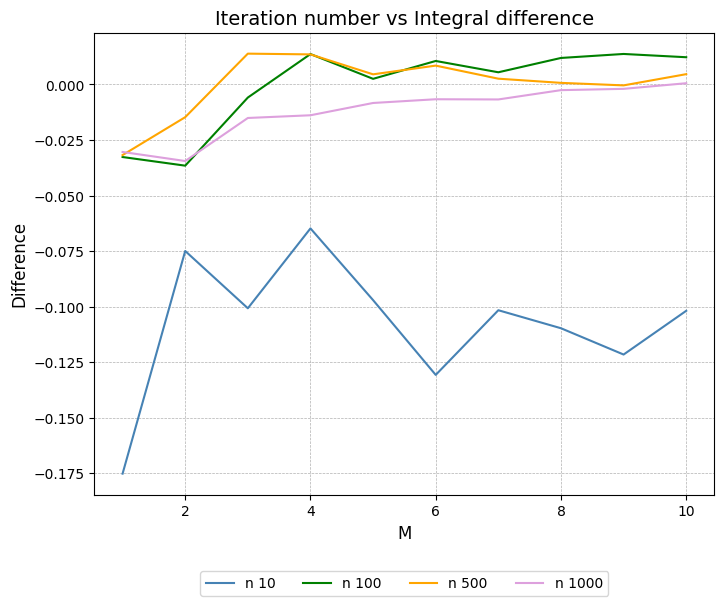

In [26]:
d_1 = [results_dict_lis_back_geom_t[(i, 10)]['mean_ratio'] - 5.000075 for i in list(range(1, 11, 1))]
d_2 = [results_dict_lis_back_geom_t[(i, 100)]['mean_ratio'] - 5.000075 for i in list(range(1, 11, 1))]
d_3 = [results_dict_lis_back_geom_t[(i, 500)]['mean_ratio'] - 5.000075 for i in list(range(1, 11, 1))]
d_4 = [results_dict_lis_back_geom_t[(i, 1000)]['mean_ratio'] - 5.000075 for i in list(range(1, 11, 1))]

m = list(range(1, 11, 1))

# Plotting
plt.figure(figsize=(8, 6))  # Adjust figure size

plt.plot(m, d_1, label="n 10",  color='steelblue')
plt.plot(m, d_2, label="n 100",  color='green')
plt.plot(m, d_3, label="n 500",  color='orange')
plt.plot(m, d_4, label="n 1000",  color='plum')

# Adding labels and title
plt.xlabel('M', fontsize=12)
plt.ylabel('Difference', fontsize=12)
plt.title('Iteration number vs Integral difference', fontsize=14)

# Adding a legend
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)

# Adding gridlines
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Show plot
plt.show()

selecting <span style="color:lightblue"> sigma </span> and<span style="color:lightblue"> M </span> .

In [27]:
# defining parameters
alpha = np.array([1, 1, 1, 1, 1])           # Alpha for the target distribution
n = np.array([0, 0, 1, 0 ,0])               # Values for n
alpha_proposal = np.array([4, 4, 4, 4, 4])  # Alpha for the Dirichlet proposal (e.g., uniform)
num_samples = 10                            # Number of samples to draw
sigma = 500                                 # Set sigma value as needed

# defining ranges for eta and bigm checkpoints
eta_ranges = [np.linspace(0, 1, 10), np.linspace(0, 1, 100), np.linspace(0, 1, 500), np.linspace(0, 1, 1000)]
eta_part = [10, 100, 500, 1000]
bigm_checkpoints = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

# dictionary to store results for each bigm and eta combination
results_dict_lis_back_opt_t = run_lis_experiment(eta_ranges=eta_ranges,
                                                 alpha=alpha,
                                                 proposal_distribution=proposal_distribution,
                                                 wrapped_log_objective_function=wrapped_log_objective_function,
                                                 alpha_proposal=alpha_proposal,
                                                 met_obj=mh.met,
                                                 M=10,
                                                 stepsize=stepsize,
                                                 bigm_checkpoints=bigm_checkpoints,
                                                 eta_part=eta_part,
                                                 init=False,
                                                 iratios=0.2)

Checkpoint reached: eta = 10, BigM = 1, mean_ratio = 5.202979535646612
Checkpoint reached: eta = 10, BigM = 2, mean_ratio = 5.140091522835574
Checkpoint reached: eta = 10, BigM = 3, mean_ratio = 5.093356708685427
Checkpoint reached: eta = 10, BigM = 4, mean_ratio = 5.068191458196375
Checkpoint reached: eta = 10, BigM = 5, mean_ratio = 5.053168932763431
Checkpoint reached: eta = 10, BigM = 6, mean_ratio = 5.010208261945175
Checkpoint reached: eta = 10, BigM = 7, mean_ratio = 5.006060623511144
Checkpoint reached: eta = 10, BigM = 8, mean_ratio = 4.978305159048493
Checkpoint reached: eta = 10, BigM = 9, mean_ratio = 4.984784598487219
Checkpoint reached: eta = 10, BigM = 10, mean_ratio = 4.988856058969492
Checkpoint reached: eta = 100, BigM = 1, mean_ratio = 4.985819642372965
Checkpoint reached: eta = 100, BigM = 2, mean_ratio = 4.967071914123646
Checkpoint reached: eta = 100, BigM = 3, mean_ratio = 4.973893063777555
Checkpoint reached: eta = 100, BigM = 4, mean_ratio = 4.999828384287824
C

### Methods Comparison

#### AIS computational time

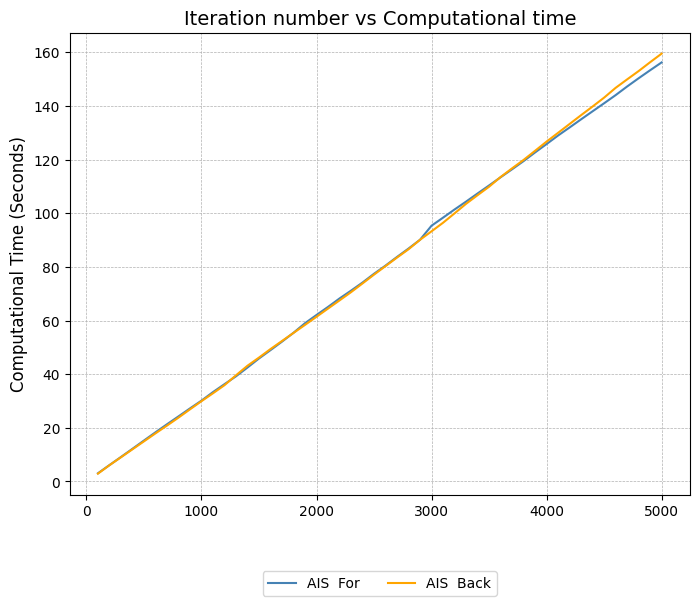

In [28]:
# retrieving computational time for AIS
a_1 = [np.sum(results_dict_ais_for_t[(i, 500)]['times']) for i in list(range(100, 5100, 100))]
a_2 = [np.sum(results_dict_ais_back_t[(i, 500)]['times']) for i in list(range(100, 5100, 100))]

# retrieiving m
m= list(range(100, 5100, 100))

# plotting
plt.figure(figsize=(8, 6))
plt.plot(m, a_1, label="AIS  For",  color='steelblue')
plt.plot(m, a_2, label="AIS  Back",  color='orange')

# adjusting plot layout 
plt.ylabel('Computational Time (Seconds)', fontsize=12)
plt.title('Iteration number vs Computational time', fontsize=14)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# showing plot
plt.show()

#### LIS computational times

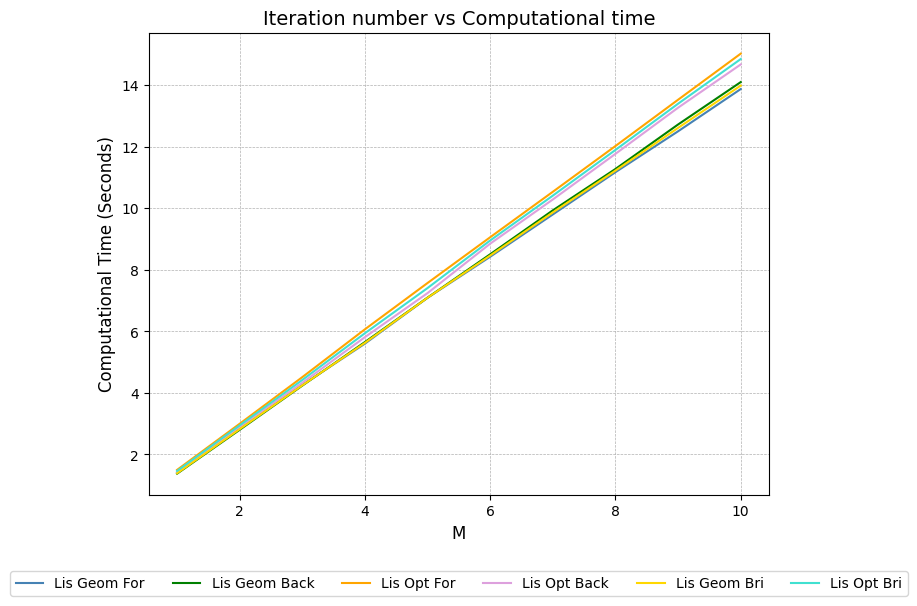

In [29]:
# retrieving computational time
l_1 = [np.sum(results_dict_lis_for_geom_t[(i, 500)]['times']) for i in list(range(1, 11, 1))]
l_2 = [np.sum(results_dict_lis_back_geom_t[(i, 500)]['times']) for i in list(range(1, 11, 1))]
l_5 = [(l_1[i] + l_2[i])/2 for i in range(len(l_1))]
l_3 = [np.sum(results_dict_lis_for_opt_t[(i, 500)]['times']) for i in list(range(1, 11, 1))]
l_4 = [np.sum(results_dict_lis_back_opt_t[(i, 500)]['times']) for i in list(range(1, 11, 1))]
l_6 = [(l_3[i] + l_4[i])/2 for i in range(len(l_1))]

# storing the ranges
m= list(range(1, 11, 1))

# plotting
plt.figure(figsize=(8, 6))  # Adjust figure size
plt.plot(m, l_1, label="Lis Geom For",  color='steelblue')
plt.plot(m, l_2, label="Lis Geom Back",  color='green')
plt.plot(m, l_3, label="Lis Opt For",  color='orange')
plt.plot(m, l_4, label="Lis Opt Back",  color='plum')
plt.plot(m, l_5, label="Lis Geom Bri",  color='gold')
plt.plot(m, l_6, label="Lis Opt Bri",  color='turquoise')

# adjusting the plot layout 
plt.xlabel('M', fontsize=12)
plt.ylabel('Computational Time (Seconds)', fontsize=12)
plt.title('Iteration number vs Computational time', fontsize=14)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=6)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# showing plot
plt.show()

#### Overall performances

In [30]:
# retrieving results
d_1 = [results_dict_lis_for_geom_t[(i, 500)]['mean_ratio']  for i in range(1, 6)]
d_2 = [results_dict_lis_back_geom_t[(i, 500)]['mean_ratio'] for i in range(1, 6)]
d_3 = [results_dict_lis_for_opt_t[(i, 500)]['mean_ratio']  for i in range(1, 6)]
d_4 = [results_dict_lis_back_opt_t[(i, 500)]['mean_ratio']  for i in range(1, 6)]
b_1 = abs(results_dict_ais_for_t[(2000, 1000)]['mean_ratio'] - 1.99997e-1)
b_2 = abs(results_dict_ais_back_t[(1000, 500)]['mean_ratio'] - 5.000075)
b_3 = abs(results_dict_lis_for_geom_t[(6, 500)]['mean_ratio'] - 1.99997e-1)
b_4 = abs(results_dict_lis_back_geom_t[(6, 500)]['mean_ratio'] - 5.000075)
b_5 = abs(results_dict_lis_for_opt_t[(6, 500)]['mean_ratio'] - 1.99997e-1)
b_6 = abs(results_dict_lis_back_opt_t[(6, 500)]['mean_ratio'] - 5.000075)
b_7 = np.array((1 / (1.99997e-1 / d_1[3])) / (1 / (1.99997e-1 + 1 / d_2[3]))) / 2 - 1.99997e-1
b_8 = np.array((1 / (1.99997e-1 / d_3[3])) / (1 / (1.99997e-1 + 1 / d_4[3]))) / 2 - 1.99997e-1

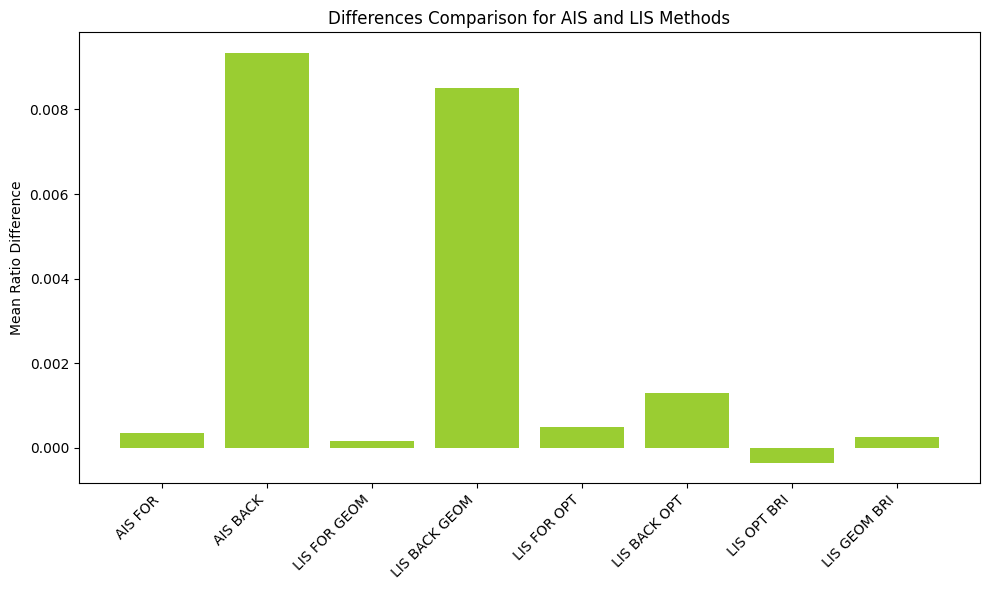

In [31]:
# values from b_1 to b_8
b_values = [b_1, b_2, b_3, b_4, b_5, b_6, b_7, b_8]

# labels for each bar
labels = [
    'AIS FOR', 
    'AIS BACK', 
    'LIS FOR GEOM', 
    'LIS BACK GEOM', 
    'LIS FOR OPT', 
    'LIS BACK OPT', 
    'LIS OPT BRI', 
    'LIS GEOM BRI'
]

# making the bar plot
x = np.arange(len(b_values))  # X axis positions
plt.figure(figsize=(10, 6))   # Set the figure size

# creating the bars and color them greenyellow
plt.bar(x, b_values, color='yellowgreen')

# adding labels, title, and adjust ticks
plt.xticks(x, labels, rotation=45, ha="right")  # Rotate labels for better readability
plt.ylabel('Mean Ratio Difference')
plt.title('Differences Comparison for AIS and LIS Methods')

# showing plot
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()